# 量子敵対的生成ネットワーク

## はじめに

[敵対的](gloss:adversarial) 生成ネットワーク(GANs) [[1]](https://arxiv.org/abs/1406.2661) は写実的な画像生成が可能で、教師なし学習において最も広く使われている手法の一つとして急速に注目されてきています。 古典的GANsが成功を収めている中で、量子コンピューティングを活用したGANも成功するかどうかが自然な疑問として考えられます。このページでは量子敵対的生成ネットワーク(QGANs) の背後にある理論について探り、また [ガウス分布](gloss:gaussian-distribution) について学習するためにQiskitを用いてQGANsの一つを実装する演習を行います。最後に量子敵対的生成ネットワークの潜在的なユースケースについての議論とより深く勉強したい人のために関連する研究を示して終わります。

## 古典的生成モデル (理論)

### 生成モデル

最近までは教師あり学習モデルの成功によって生成モデルは完全に日の目を見ませんでした。これらの教師あり学習の高い評判が機械学習の他のアプローチの概念化さえも難しくしていたかもしれません。

もう私たちには直感的に感じますが、教師ありのアプローチは新しいデータに対して正確な予測をしようとし、データセットに潜むいくつかの関係を学習したことを示します。生成モデルは教師ありのアプローチとは異なります。入力データとラベルとの間の重要な関係について焦点を当てる代わりに、根本に潜む分布を全体的にモデル化するために学習します。これによって新しいデータのサンプルを生成することができます。これは猫か犬かを区別することと、猫と犬の完全に新しい画像を生成することの違いにあたります。後者はより富んでいますが、同様により難しい課題になります。

なぜより難しいのでしょうか。 高次元空間内の有力な決定境界を形作るのに役立つ少数の真実を明らかにする特徴量（例えば、目にはつかない髭）を選び出すことで、しばしば与えられたデータ間の判別を十分に行うことができます。結果として、機械学習の研究者はより深い学習の概念を突き詰めているように見える学習課題として背後にある *クリエイター* 関数を再現しようとする生成モデルに多大な関心を抱いています。

従って訓練データの塊が与えられたとき、生成モデルの目標はデータを生成する確率分布を学習/再現することです。GANsの特に目を引く応用として[ 高解像度の映像](https://thispersondoesnotexist.com/) の生成や[ 作曲](https://magenta.tensorflow.org/gansynth) があります。下図は偽の猫の生成画像です。

![computer-generated image of a cat](https://thiscatdoesnotexist.com/)

<!-- ::: q-block.exercise -->

### クイッククイズ

<!-- ::: q-quiz(goal="qml-qgan-0") -->

<!-- ::: .question -->

生成モデルの学習課題として最も適切なものはどれでしょうか。

<!-- ::: -->

<!-- ::: .option(correct) -->

1. 手書き数字の画像生成

<!-- ::: -->

<!-- ::: .option -->

1. 受信メールが迷惑メールかそうでないかの分類

<!-- ::: -->

<!-- ::: .option -->

1. 株価の予測

<!-- ::: -->

<!-- ::: .option -->

1. 最適な映画の推薦

<!-- ::: -->

<!-- ::: -->

<!-- ::: -->

### 敵対的生成ネットワーク

生成モデルのある特定のクラスである敵対的生成ネットワーク(GANs)は2014年にGoodfellow I., *et al.* [[1]](https://arxiv.org/abs/1406.2661) で最初に提案されて以来、人気沸騰中です。 量子のアナロジーを理解するために最初に簡単に古典的敵対的生成ネットワークの概念について議論します。

一言で言うとGANsは生成器と識別器という互いに競争し合う対のニューラルネットワークを用います。

### 生成器

生成器の主な目的は識別器が本物だと十分に確信するような偽のデータサンプルを作り出すことです。本物のデータの固定された確率分布とほぼ完全に重なるまで、それぞれの訓練ステップで生成器は偽のデータサンプルの改良を行います。

生成器が非決定論的に出力の空間を十分に探索できるように、生成器には入力として[ 潜在空間](gloss:latent-space) から取り出された（たいていはガウス分布でサンプリングされます）ランダムノイズベクトルを与えます。（ガウシアンノイズの）潜在空間の大半の点を本物の分布に合うようにフィッティングされたと確信させる偽のデータサンプルに一度、写すことができれば生成器は成功したと言えます。

*訓練開始時は潜在空間は意味のないn次元のガウス分布です。しかし生成器が進化するにつれて、生成器は潜在空間のノイズベクトルを目的とするデータセット内の有効なデータに写すことを学習します。*

### 識別器

識別器は生成器と本物の分布の両方から（どちらがどちらかは分からない状態で）データサンプルを受け取ります。識別器の課題は入力されたデータサンプルが偽物か本物かを正しく分類することです。

識別器の目標は生成器の目標と正反対であることに注意してください。識別器は偽物のデータを本物のデータと誤分類する確率を最小化しようとする一方で、生成器は誤分類する確率を最大化しようとします。![敵対的生成ネットワークのフローチャート](images/qgan/gan_general_flow.svg)

### 収束性

生成器が本物のデータと見分けがつかないような説得力のあるデータサンプルを一貫して生成するようになり、識別器が合理的に偽のデータと真のデータを判読できなくなったら、GANの訓練を終了します。この点は正式には（ゲーム理論の用語で）ナッシュ均衡と呼ばれ、生成器は本物の確率分布と一致するデータを生成し、 *訓練済みの* 識別器は偽物か本物かの識別を（50%の精度の）推測に頼ります。

GANをよく知られているように美術品の盗難に例えることで、そのコンセプトがわかります。生成器は美術館に置かれているものとそっくりな絵画を作ろうとする偽の画家に見立てられることがしばしばあります。芸術の専門家（識別器）の目的は生成器による偽の作品か本物の作品かを見分けることです。このアナロジーの下では、識別器は絵画の真贋を評価し、一方で生成器は識別器をだますのに最高の贋作を作ります。このゼロサムゲームは二つのネットワークが常にお互いを上回ろうとすることを後押しします。説得力のあるデータを作る生成器の改良は改善された分類をしようと更新をする識別器に出し抜かれ、その逆も然りです。

![GANのアナロジー](images/qgan/gan_analogy.png)

<!-- ::: q-block.exercise -->

### クイッククイズ

<!-- ::: q-quiz(goal="qml-qgan-1") -->

<!-- ::: .question -->

GANがナッシュ均衡に一度達すると...

<!-- ::: -->

<!-- ::: .option(correct) -->

1. 識別器は偽物か本物かを等確率でランダムに推測する

<!-- ::: -->

<!-- ::: .option -->

1. 生成器はノイズを生成する状態に戻る。

<!-- ::: -->

<!-- ::: .option -->

1. GANは共通の失敗モードに達し、訓練過程を再開始しなければならない。

<!-- ::: -->

<!-- ::: .option -->

1. 識別器は全てのサンプルが本物だと推定する。

<!-- ::: -->

<!-- ::: -->

<!-- ::: -->

## 量子敵対的生成ネットワーク（理論）

2018年に同時期に発表された二つの論文 ([[2]](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.98.012324), [[3]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.121.040502)) によって量子の領域にGANの考えが持ち込まれました。ざっくりと言うと量子敵対的生成ネットワーク(QGANs)は識別器と生成器の一方または両方が [ パラメータ化された回路](./paramterized-quantum-circuits)によって実装され、いくつかの量子または古典のデータを学習することが目標です。この章では完全な量子版のQGANs（量子生成器、量子識別器）について議論しますが、幅広い原則が他の種類のQGANsにも適用されることを覚えておいてください。

![QGANの先行研究のランドスケープ](images/qgan/past_work_landscape.svg)  

参考文献 [5](https://arxiv.org/abs/1901.00848) から引用

GANsとQGANsの間には、特に敵対的学習に関してですが、多くの類似した概念があります。最も重要なのは GANsの学習構造の大部分がQGANsでも踏襲されていることです。生成器と識別器の回路のパラメーターを学習させる代わりに他のパラメーターは固定します。これにより、GANsと同様にして識別器の信号の代理から量子生成器はターゲットの量子状態を学習します。量子敵対的ゲームも同様に生成器がターゲットの分布と同じデータを生成するときに[安定な平衡状態](https://en.wikipedia.org/wiki/Nash_equilibrium) になることが示されています。[[3]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.121.040502).

完全に量子のQGANにおける目的は、もちろん敵対的学習の戦略を用いて、量子生成器に望みの状態 $|\psi\rangle$ を再現させることです。他の変分量子アルゴリズムと同様に、古典的オプティマイザーによってパラメーターを反復的に更新して、量子生成器はこの状況に向かいます。しかしながらQGANの場合では生成器のコスト関数のランドスケープはそれ自体が進化し、また識別器の本物のサンプルの識別能力が改善されるにつれて、より良くなります。これからビルドする一般の回路の回路図について見ていきましょう。

![real_rig](images/qgan/real_rig.svg)

![fake_rig](images/qgan/fake_rig.svg)

特筆すべき点として、ここでは生成器と識別器の両方についてそれぞれ1つのレジスターしか考えませんが、[補助](gloss:auxiliary)"ワークスペース"レジスターを生成器と識別器の両方に加えることもできます。 

上記で描画されている二つの回路では生成器は識別器に連結していて、ターゲットデータを読み込むユニタリーは識別器と連結していることが分かります。

識別器は $|0\rangle$ の状態の追加の1量子ビットだけでなく、生成器とターゲットデータのユニタリーのそれぞれの出力にも作用します。最終的に、追加の1量子ビットに対して測定をすることで識別器は分類を行います。 $|0\rangle$ に対応する結果のときは入力データは本物、 $|1\rangle$ に対応する結果のときは入力データは偽物とそれぞれ分類されます。

一つ目の回路図を見ると、本物のデータがどのように識別器に送られるかが分かります。私たちは完全に量子のQGANを扱っているので、持っている本物のデータを識別器に入力する量子状態に何らかの方法でエンコードする必要があります。そのためにユニタリー $\class{u-sub-r}{U_R}$ を用いて本物のデータを以下のように定義します。

$$|\text{Data}_R\rangle= U_R|0\rangle^{\otimes n}$$

この状態は（補助レジスターを含む可能性のある）パラメーター化された識別器  $U_{D(\class{theta-d}{\vec{\theta_D}})}$ に入力され、本物のデータに対する識別器のスコアが測定によって求められます。 $U_{D(\class{theta-d}{\vec{\theta_D}})}$ は識別器のレジスター（ワークスペース）に本物のデータに関係のある特徴を"移す"ために、エンタングルさせる2量子ビットゲートをいくつか含むことは注目に値します。ユニタリー発展を定式化すると

$$\class{u-sub-d}{U}_{D(\class{theta-d}{\vec{\theta_D}})}(|\text{Data}_R\rangle \otimes |0\rangle)$$ 

となります。

ここで $\class{theta-d}{\vec{\theta_D}}$ は最後の量子ビットについての[期待値](gloss:expectation-value) を最小化するように（これは識別器が本物のデータを  $|\text{real}\rangle$ と分類する確率を最大化することと等しいです。）古典的なオプティマイザーで更新されるパラメーターベクトルです。

二つ目の回路では本物の[波動関数](gloss:wave-function)を模倣することを目的として生成された波動関数が識別器に送られています。言い換えると、以下のように  $\class{theta-g}{\vec{\theta_G}}$ でパラメーター化されている  $U_{G(\class{theta-g}{\vec{\theta_G}})}$ を $|0^{\otimes n}\rangle$ の初期状態に作用させることで偽物の量子状態が用意されます。

$$|\text{Data}_G\rangle = U_{G(\class{theta-g}{\vec{\theta_G}})}|0^{\otimes n}\rangle$$

`{latex}|\text{Data}_G\rangle` は`{latex}\class{theta-d}{\vec{\theta_D}}` でパラメーター化された識別器に入力されます。 物理量 `{latex}I^{\otimes n}Z` について`{latex}U_{D(\class{theta-d}{\vec{\theta_D}})}(|\text{Data}_G\rangle  \otimes |0\rangle)` のもとで期待値をとることで偽物のデータに対する識別器のスコアが得られます。

 与えられたサンプルはからっきし偽物であることを”識別器が信じている”ことを意味する $\langle \text{fake} | Z  | \text{fake} \rangle = 1$ は最後の量子ビットに対する $Z$ の期待値が1に等しいことを再度確認する価値があります。すると識別器は偽物のサンプルに対しては $|0\rangle$ を、本物のサンプルに対しては $|1\rangle$ を正しく"割り当て"たいと考えるのが自然になります。生成器に対しては逆があてはまります。生成器にとって最善なシナリオは、生成器によって生成された量子状態が本物だと識別器が完全に確信する、従ってそれに $|1\rangle$ を割り当てることです。これらの敵対するインセンティブは（[参考文献2](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.98.012324)を参考にすると）以下の[ミニマックス](gloss:minimax) 決定法則として定式化できます。

$$\underset{\class{theta-g}{\vec{\theta_G}}}{\min}\underset{\class{theta-d}{\vec{\theta_D}}}{\max}
\hspace{3pt} \Bigg(\class{pr}{\text{Pr}}\bigg(\class{d-disc}{D}(\class{theta-d}{\vec{\theta_D}}, R) = |\text{real}\rangle\bigg) +  \hspace{2pt} \class{pr}{\text{Pr}}\bigg(\class{d-disc}{D}(\class{theta-d}{\vec{\theta_D}}, G(\class{theta-g}{\vec{\theta_G}})) = |\text{fake}\rangle\bigg)\Bigg)$$

<!-- ::: q-block.exercise -->

### クイッククイズ

<!-- ::: q-quiz(goal="qml-qgan-2") -->

<!-- ::: .question -->

クイズ問題: どのようにして与えられたデータサンプルが本物であると識別器があてがう確率は得られるでしょうか。 $\langle Z \rangle$ は最後の量子ビットに対する $Z$ の期待値とします。

<!-- ::: -->

<!-- ::: .option -->

1. $\langle Z\rangle + 1$

<!-- ::: -->

<!-- ::: .option -->

1. $\langle Z\rangle + 1/2$

<!-- ::: -->

<!-- ::: .option(correct) -->

1. $\frac{\langle Z \rangle + 1}{2}$

<!-- ::: -->

<!-- ::: .option -->

1. $2^{\langle Z \rangle}$

<!-- ::: -->

<!-- ::: -->

ヒント: Zの期待値は $[-1, 1]$ に抑えられます。

<!-- ::: -->

## 完全な実装 I

### 2量子ビットのベル状態の学習

十分に理論的な基礎が身についたので、私たちは今、Qiskitを使って2量子ビットのベル状態を学習する現実のQGANをビルドすることができます！最初に標準的なライブラリーをインポートします。

In [1]:
import numpy as np
from qiskit import QuantumCircuit, Aer
from qiskit.visualization import plot_histogram

### 本物の分布の定義

2量子のベル状態は最大にエンタングルした量子状態で、私たちが再現することに関心を持っている特定の状態ベクトルは $|\psi\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle) $ です。これはアダマールゲートの後にCNOTゲートを適用することで構築できます。

In [2]:
# Number of qubits needed to model real distribution
REAL_DIST_NQUBITS = 2
real_circuit = QuantumCircuit(REAL_DIST_NQUBITS)
real_circuit.h(0)
real_circuit.cx(0, 1);

<!--- TODO: Widget: mini composer Have them compose Bell state of interest defined above. Stops when constructs properly --->

### 変分量子生成器と識別器の定義

ここで生成器のansatzを定義します。

QGANの研究は始まったばかりなので、コミュニティにおいて最適な生成器や識別器のansatzはまだ見つかっていません。それに関連して、量子機械学習において選ばれる[ハイパーパラメーター](gloss:hyperparameter)の大半は依然として緩い[ヒューリスティックス](gloss:heuristics)で動かされ、まだ探究する余地が多くあります。

特筆すべきこととして、生成器としてどんなansatzを選んだとしても、生成器は前述の本物の量子状態 $|\psi\rangle$ を完全に再現するのに十分な[キャパシティー](gloss:capacity)と[表現可能性](gloss:expressible)を持ち合わせているに違いないということがあります。このため、ここで用いるansatzには少し任意性があるものの、モデル化しようとしているベル状態に対して生成器は十分な表現力があると私たちは自信を持てます。

In [3]:
# Import qiskit machine learning parameters
from qiskit.circuit import ParameterVector

ここでは`TwoLocal` クラスにより、エンタングルさせるゲート$CZ$と1量子ビットゲート $RY$、 $RZ$ を組み合わせて構成される変分量子生成器のansatzを生成します。

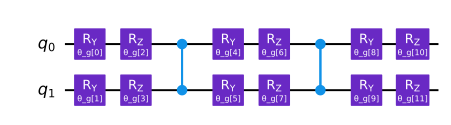

In [4]:
from qiskit.circuit.library import TwoLocal
generator = TwoLocal(REAL_DIST_NQUBITS,
                     # Parameterized single qubit rotations
                     ['ry', 'rz'],
                     'cz',  # Entangling gate
                     'full', # Entanglement structure: all to all
                     reps=2, # Number of layers
                     parameter_prefix='θ_g',
                     name='Generator')
generator = generator.decompose() # decompose into standard gates
generator.draw()

### 変分量子識別器

ここでは識別器のansatzを定義します。今回は[`TwoLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html#qiskit.circuit.library.TwoLocal)を用いる代わりにカスタム ansatz を [`ParameterVector`](https://qiskit.org/documentation/stubs/qiskit.circuit.ParameterVector.html)で生成します。

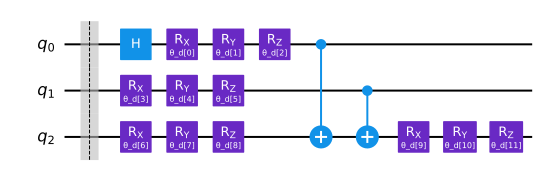

In [5]:
disc_weights = ParameterVector('θ_d', 12)
discriminator = QuantumCircuit(3, name="Discriminator")
discriminator.barrier()
discriminator.h(0)
discriminator.rx(disc_weights[0], 0)
discriminator.ry(disc_weights[1], 0)
discriminator.rz(disc_weights[2], 0)
discriminator.rx(disc_weights[3], 1)
discriminator.ry(disc_weights[4], 1)
discriminator.rz(disc_weights[5], 1)
discriminator.rx(disc_weights[6], 2)
discriminator.ry(disc_weights[7], 2)
discriminator.rz(disc_weights[8], 2)
discriminator.cx(0, 2)
discriminator.cx(1, 2)
discriminator.rx(disc_weights[9], 2)
discriminator.ry(disc_weights[10], 2)
discriminator.rz(disc_weights[11], 2)
discriminator.draw()

### QGANのコンパイル

すべての部品が揃ったので、次にQGANを形成する二つの回路を構築します。一つ目の回路では生成器によって作られた量子状態を識別器に入力します。二つ目の回路は本物の状態が入力される識別器で構成されます。 *どのようにして、この回路が上記で大まかに述べた一般的な回路に対応するかは簡単に確認できます。*

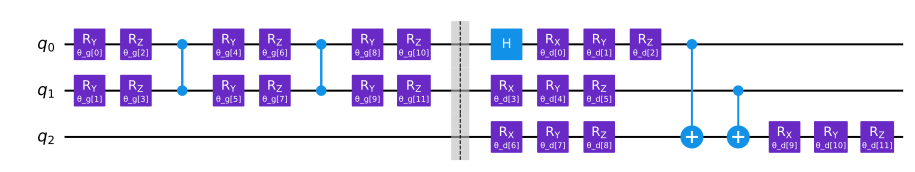

In [6]:
N_GPARAMS = generator.num_parameters
N_DPARAMS = discriminator.num_parameters
# Need extra qubit for the discriminator
gen_disc_circuit = QuantumCircuit(REAL_DIST_NQUBITS+1)
gen_disc_circuit.compose(generator, inplace=True)
gen_disc_circuit.compose(discriminator, inplace=True)
gen_disc_circuit.draw()

ここで当たり前の疑問として、生成器にノイズを入れないのは何故かということが挙げられます。覚えているかもしれませんが、古典的なGANでは潜在空間は必要不可欠な要素でした。もし古典的GANでノイズを入れなかった場合はパラメーターのそれぞれの更新が決定論的になり、生成器の出力は一つのサンプルに制限されるため、生成器が分布を完全に表現することは不可能になります。しかし量子の場合を考えると、すべての”偽物の”波動関数を直接識別器に入力するため、ノイズの役割はそれほど明らかではありません。ノイズの有無に関係なくansatzのキャパシティーが十分ありさえすれば、変分量子生成器は関心のある波動関数を直接モデル化する能力を持ちます。

とは言え、変分量子生成器に対して潜在空間を用意することの利点はあるかもしれません。実際、[参考文献5](https://arxiv.org/abs/1901.00848)では潜在空間を入力として用いることで、量子生成器が連続分布をモデル化する手法が示されています。しかし簡単のため、私たちは変分量子生成器にノイズを入力することは省略します。

以下では変分識別器とターゲットの分布を結びつけるパラメーター化された回路を定義します。

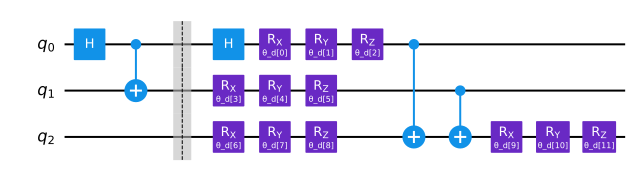

In [7]:
real_disc_circuit = QuantumCircuit(REAL_DIST_NQUBITS+1)
real_disc_circuit.compose(real_circuit, inplace=True)
real_disc_circuit.compose(discriminator, inplace=True)
real_disc_circuit.draw()

### コスト関数の構築

上述したミニマックス決定法則を思い出してください。

$$\underset{\class{theta-g}{\vec{\theta_G}}}{\min}\underset{\class{theta-d}{\vec{\theta_D}}}{\max}
\hspace{3pt} \Bigg(\class{pr}{\text{Pr}}\bigg(\class{d-theta}{D(\class{theta-d}{\vec{\theta_D}}, R)} = |\text{real}\rangle\bigg) +  \hspace{2pt} \class{pr}{\text{Pr}}\bigg(D(\class{theta-d}{\vec{\theta_D}}, G(\class{theta-g}{\vec{\theta_G}})) = |\text{fake}\rangle\bigg)\Bigg)$$

識別器と生成器の両方に対する損失関数を構築することは今や造作もないです。まず識別器については、

$$\text{Cost}_D = \class{pr}{\text{Pr}}\bigg(D(\class{theta-d}{\vec{\theta_D}}, G(\class{theta-g}{\vec{\theta_G}})) = |\text{real}\rangle\bigg) - \class{pr}{\text{Pr}}\bigg(D(\class{theta-d}{\vec{\theta_D}}, R) = |\text{real}\rangle\bigg)$$
となります。

これを最小化するには、偽物のデータを誤分類する確率を最小化する一方で、本物のデータを正しく分類する確率を最大化することが必要になります。<br>普通のGANsの特徴としては生成器のコスト関数は単に識別器のコスト関数の逆符号をとるだけで、最適化戦略は識別器が偽物のデータを誤分類する確率を最大化することです。本物の量子状態に関する項については生成器の重みは影響を与えないので省きます。

$$\text{Cost}_G =  - \class{pr}{\text{Pr}}\bigg(D(\class{theta-d}{\vec{\theta_D}}, G(\class{theta-g}{\vec{\theta_G}})) = |\text{real}\rangle\bigg)$$

上記のコスト関数を実装します。それぞれの基底状態の確率を評価した後に、 $|XX1\rangle$ （最後の量子ビットが $|1\rangle$ と測定される任意の状態）の形を満たす基底状態を得る確率について和をとることで、与えられたサンプルが $|\text{real}\rangle = |1\rangle$ と分類される合計の確率を求められることに注目してください。ただし、Qiskitの[エンディアン](gloss:endian)では $|1XX\rangle$ と順番が逆になることに注意してください。

In [8]:
# We'll use Statevector to retrieve statevector of given circuit
from qiskit.quantum_info import Statevector
import tensorflow as tf

def generator_cost(gen_params):
    """Generator cost function for the optimizer to minimize."""
    # .numpy() method extracts numpy array from TF tensor
    curr_params = np.append(disc_params.numpy(),
                            gen_params.numpy())
    state_probs = Statevector(gen_disc_circuit
                              .bind_parameters(curr_params)
                             ).probabilities()
    # Get total prob of measuring |1> on q2
    prob_fake_true = np.sum(state_probs[0b100:])
    cost = -prob_fake_true
    return cost

def discriminator_cost(disc_params):
    """Discriminator cost function for the optimizer to minimize."""
    # .numpy() method extracts numpy array from TF tensor
    curr_params = np.append(disc_params.numpy(),
                            gen_params.numpy())
    gendisc_probs = Statevector(gen_disc_circuit
                                .bind_parameters(curr_params)
                               ).probabilities()
    realdisc_probs = Statevector(real_disc_circuit.
                                 bind_parameters(disc_params.numpy())
                                ).probabilities()
    # Get total prob of measuring |1> on q2
    prob_fake_true = np.sum(gendisc_probs[0b100:])
    # Get total prob of measuring |1> on q2
    prob_real_true = np.sum(realdisc_probs[0b100:])
    cost = prob_fake_true - prob_real_true
    return cost

 ここで、モデルとターゲットの分布間の[カルバック・ライブラーダイバージェンス](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) を計算するヘルパー関数を定義します。これは二つの分布間の距離を効果的に測るため、生成器の学習過程を追うのによく用いられるメトリックです。KLダイバージェンスが低いことは二つの分布が似ていることを示し、KLダイバージェンスが0のときは二つの分布は同じであることを表します。

In [9]:
def calculate_kl_div(model_distribution: dict, target_distribution: dict):
    """Gauge model performance using Kullback Leibler Divergence"""
    kl_div = 0
    for bitstring, p_data in target_distribution.items():
        if np.isclose(p_data, 0, atol=1e-8):
            continue
        if bitstring in model_distribution.keys():
            kl_div += (p_data * np.log(p_data)
                 - p_data * np.log(model_distribution[bitstring]))
        else:
            kl_div += p_data * np.log(p_data) - p_data * np.log(1e-6)
    return kl_div

### CircuitQNN

簡単のために、パラメーター化された回路をコンパイルし、勾配法の計算を扱う[`CircuitQNN`](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.CircuitQNN.html) を使います。`forward()` メソッドを呼び出すことでも同様に回路の確率状態ベクトルを直接、出力します。

In [10]:
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.neural_networks import CircuitQNN

# define quantum instances (statevector and sample based)
qi_sv = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

# specify QNN to update generator weights
gen_qnn = CircuitQNN(gen_disc_circuit,  # parameterized circuit
                     # frozen input arguements (discriminator weights)
                     gen_disc_circuit.parameters[:N_DPARAMS],
                     # differentiable weights (generator weights)
                     gen_disc_circuit.parameters[N_DPARAMS:],
                     sparse=True, # returns sparse probability vector
                     quantum_instance=qi_sv)

# specify QNNs to update discriminator weights
disc_fake_qnn = CircuitQNN(gen_disc_circuit, # parameterized circuit
                           # frozen input arguments (generator weights)
                           gen_disc_circuit.parameters[N_DPARAMS:],
                           # differentiable weights (discrim. weights)
                           gen_disc_circuit.parameters[:N_DPARAMS],
                           sparse=True, # get sparse probability vector
                           quantum_instance=qi_sv)

disc_real_qnn = CircuitQNN(real_disc_circuit, # parameterized circuit
                           [], # no input parameters
                           # differentiable weights (discrim. weights)
                           gen_disc_circuit.parameters[:N_DPARAMS],
                           sparse=True, # get sparse probability vector
                           quantum_instance=qi_sv)

ここでは生成器と識別器の両方に対してADAMオプティマイザーのインスタンスを作るために[TensorFlow Keras](gloss:tensorflow-keras)を使います。ADAMオプティマイザーは古典的な機械学習で広く用いられているオプティマイザーで、モーメンタムベースの勾配更新を行います。これは普通の勾配降下よりもかなり優れていることが知られています。

Kerasのオプティマイザーを使うために重みをTFの変数として記憶しなければなりません。これは`tf.Variable` メソッドにより簡単に実行できます。`tf.Variable`に対して`.numpy()` のインスタンスメソッドを使えば元の`np.ndarray`に変換して戻すことができます。

In [11]:
import tensorflow as tf
import pickle # to serialize and deserialize variables
# Initialize parameters
init_gen_params = np.random.uniform(low=-np.pi,
                                    high=np.pi,
                                    size=(N_GPARAMS,))
init_disc_params = np.random.uniform(low=-np.pi,
                                     high=np.pi,
                                     size=(N_DPARAMS,))
gen_params = tf.Variable(init_gen_params)
disc_params = tf.Variable(init_disc_params)

ランダムな重みから作られた生成器の初期状態を見てみましょう。

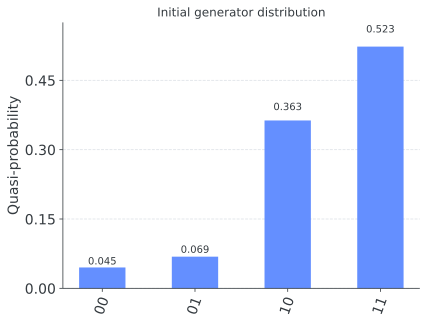

In [12]:
init_gen_circuit = generator.bind_parameters(init_gen_params)
init_prob_dict = Statevector(init_gen_circuit).probabilities_dict()

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1, 1, sharey=True)
ax1.set_title("Initial generator distribution")
plot_histogram(init_prob_dict, ax=ax1)

In [13]:
# Initialize Adam optimizer from Keras
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

### 学習

In [14]:
# Initialize variables to track metrics while training
best_gen_params = tf.Variable(init_gen_params)
gloss = []
dloss = []
kl_div = []

以下の訓練方法において重要な点がいくつかあります。

1. 1回の生成器の更新に対して、識別器の重みは5回更新されます。古典的なGANsを扱うときも、このように2つのネットワークの間で訓練ステップが偏っていることは珍しくありません。この場合は試行錯誤して得らた最良の結果として5:1の割合にたどり着きました。

2. `CircuitQNN` の `backward()` メソッドは各バッチにおいて、各基底状態に対する各パラメータに関しての勾配を返します。言い換えると、`CircuitQNN.backward(...)[1].todense()` から返される配列の形は`(num_batches, num_basis_states, num_weights)`です。従って $\text{Cost}_D$ に対する勾配を求めるには、最初に $|1XX\rangle$ の形をしているそれぞれの基底についての勾配をすべて足して、次に関数 $\text{Cost}_D$ に基づいてその和を引きます。微分の線形性を思い出すと、その操作は以下の実装のように配置できます。

3. GANの学習の不安定性のため、最良の生成器のパラメーターを保存します。

In [15]:
TABLE_HEADERS = "Epoch | Generator cost | Discriminator cost | KL Div. |"
print(TABLE_HEADERS)
for epoch in range(100):
    #--- Quantum discriminator parameter updates ---#
    D_STEPS = 5 # N discriminator updates per generator update
    for disc_train_step in range(D_STEPS):
        # Partial derivatives wrt θ_D
        d_fake = disc_fake_qnn.backward(gen_params, disc_params
                                       )[1].todense()[0, 0b100:]
        d_fake = np.sum(d_fake, axis=0)
        d_real = disc_real_qnn.backward([], disc_params
                                       )[1].todense()[0, 0b100:]
        d_real = np.sum(d_real, axis=0)
        # Recall Cost_D structure
        grad_dcost = [d_fake[i] - d_real[i] for i in range(N_DPARAMS)]
        grad_dcost = tf.convert_to_tensor(grad_dcost)
        # Update disc params with gradient
        discriminator_optimizer.apply_gradients(zip([grad_dcost],
                                                    [disc_params]))
        # Track discriminator loss
        if disc_train_step % D_STEPS == 0:
            dloss.append(discriminator_cost(disc_params))

    #--- Quantum generator parameter updates ---#
    for gen_train_step in range(1):
        # Compute partial derivatives of prob(fake|true) wrt each
        # generator weight
        grads = gen_qnn.backward(disc_params, gen_params)
        grads = grads[1].todense()[0][0b100:]
        # Recall Cost_G structure and the linearity of
        # the derivative operation
        grads = -np.sum(grads, axis=0)
        grads = tf.convert_to_tensor(grads)
        # Update gen params with gradient
        generator_optimizer.apply_gradients(zip([grads], [gen_params]))
        gloss.append(generator_cost(gen_params))

    #--- Track KL and save best performing generator weights ---#
    # Create test circuit with updated gen parameters
    gen_checkpoint_circuit = generator.bind_parameters(gen_params.numpy())
    # Retrieve probability distribution of current generator
    gen_prob_dict = Statevector(gen_checkpoint_circuit
                               ).probabilities_dict()
    # Constant real probability distribution
    real_prob_dict = Statevector(real_circuit).probabilities_dict()
    current_kl = calculate_kl_div(gen_prob_dict, real_prob_dict)
    kl_div.append(current_kl)
    if np.min(kl_div) == current_kl:
        # New best
        # serialize & deserialize to simply ensure zero links
        best_gen_params = pickle.loads(pickle.dumps(gen_params))
    if epoch % 10 == 0:
        # print table every 10 epochs
        for header, val in zip(TABLE_HEADERS.split('|'),
                              (epoch, gloss[-1], dloss[-1], kl_div[-1])):
            print(f"{val:.3g} ".rjust(len(header)), end="|")
        print()

Epoch | Generator cost | Discriminator cost | KL Div. |
    0 |         -0.431 |             -0.228 |    1.21 |
   10 |         -0.251 |             -0.715 |     1.8 |
   20 |         -0.264 |             -0.691 |    1.81 |
   30 |         -0.357 |             -0.549 |    1.13 |
   40 |         -0.417 |             -0.473 |       1 |
   50 |          -0.56 |             -0.352 |    0.82 |
   60 |          -0.74 |             -0.262 |    0.59 |
   70 |         -0.737 |             -0.211 |   0.345 |
   80 |         -0.634 |             -0.169 |   0.205 |
   90 |          -0.79 |            -0.0753 |   0.169 |


### 結果の可視化

QGANがどのように学習しているかを調べるためにメトリックの集まりをプロットします。

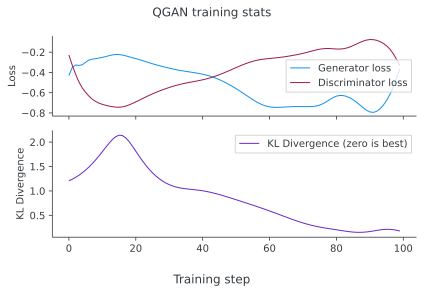

In [16]:
fig, (loss, kl) = plt.subplots(2, sharex=True,
                               gridspec_kw={'height_ratios': [0.75, 1]},
                               figsize=(6,4))
fig.suptitle('QGAN training stats')
fig.supxlabel('Training step')
loss.plot(range(len(gloss)), gloss, label="Generator loss")
loss.plot(range(len(dloss)), dloss, label="Discriminator loss",
          color="C3")
loss.legend()
loss.set(ylabel='Loss')
kl.plot(range(len(kl_div)), kl_div, label="KL Divergence (zero is best)",
        color="C1")
kl.set(ylabel='KL Divergence')
kl.legend()
fig.tight_layout();

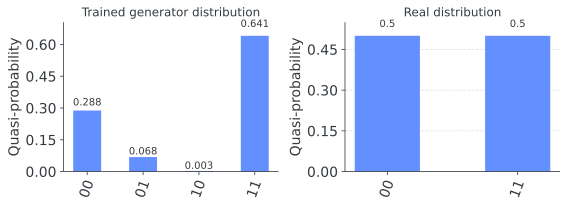

In [17]:
# Create test circuit with new parameters
gen_checkpoint_circuit = generator.bind_parameters(
    best_gen_params.numpy())
gen_prob_dict = Statevector(gen_checkpoint_circuit).probabilities_dict()
real_prob_dict = Statevector(real_circuit).probabilities_dict() # constant
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
plot_histogram(gen_prob_dict, ax=ax1)
ax1.set_title("Trained generator distribution")
plot_histogram(real_prob_dict, ax=ax2)
ax2.set_title("Real distribution")
fig.tight_layout()

たったの100 [エポック](gloss:epoch)でも、生成器がベル状態 $|\psi\rangle$ をかなり良く近似していることが見て取れます。

上記の結果を再現するのには数回の実行が必要になるかもしれないことに注意してください。同時に2つの競合するモデルを訓練することの不安定性から、敵対的生成ネットワークは全体として収束に失敗することで有名です。QGANの場合はベストプラクティスが無いため、その傾向はさらに強くなります。(QGANsも含む）GANsではしばしば識別器が良すぎることで発生する勾配消失に悩まされます。

敵対的なトレーニング構造のもう 1 つの欠点は、完全な量子 QGAN ではあまり一般的ではありませんが、生成器と識別器がいたちごっこの追跡に巻き込まれたときの GAN の故障モードであるモード崩壊があります。生成器は、識別器をだます傾向のある特定のサンプルをスパム送信します。識別器が時間をかけてそれに適応しても、生成器がすぐに別のサンプルを送信してしまうというものです。 [GAN 障害モードへの対処法について詳しくは、こちらをご覧ください](https://developers.google.com/machine-learning/gan/problems)。

## 完全な実装 II

### OpFlowQNN による正規分布の学習

次のセクションでは、途中でいくつかの以前の方法を変更しながら、3 量子ビットの正規分布を学習する QGAN を構築します。

1. より複雑な分布の学習
2. [OpFlowQNN](gloss:opflowqnn)を使用して期待値を直接取得する
3. 識別器の出力量子ビットを生成器のレジスターに統合する

### 実分布の定義

ここでは、 `qiskit_finance`モジュールと生成器 ansatz を使用して実際の分布を定義します。これは[Gaussian](gloss:gaussian-distribution)をモデル化するために使用されます。

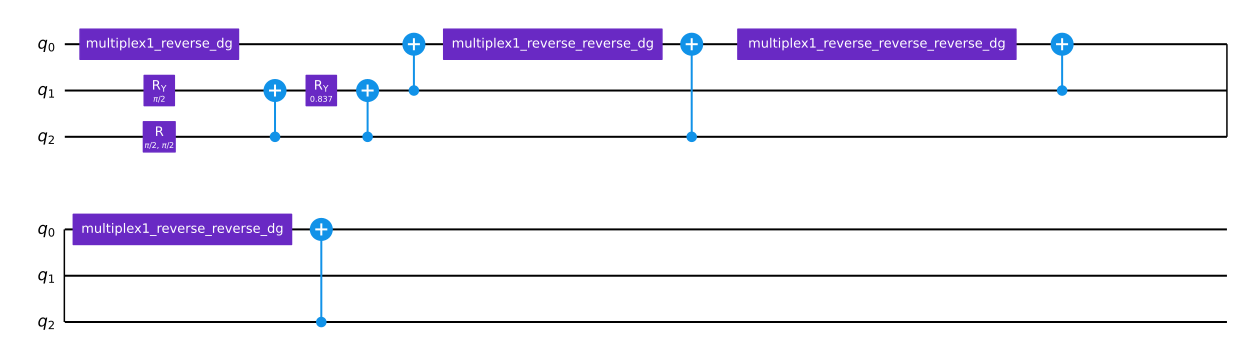

In [18]:
from qiskit_finance.circuit.library import NormalDistribution
REAL_DIST_NQUBITS = 3
real_circuit = NormalDistribution(REAL_DIST_NQUBITS, mu=0, sigma=0.15)
real_circuit = real_circuit.decompose().decompose().decompose()
real_circuit.draw()

### 変分量子識別器と生成器の定義

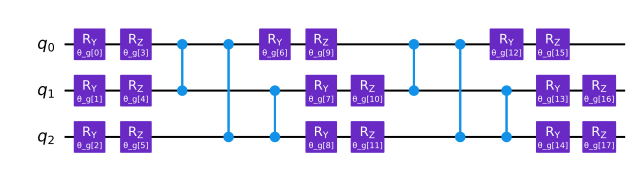

In [19]:
generator = TwoLocal(REAL_DIST_NQUBITS,
                     # Parameterized single qubit rotations
                     ['ry', 'rz'],
                     'cz',  # Entangling gate
                     'full', # Entanglement structure - all to all
                     reps=2, # Number of layers
                     parameter_prefix='θ_g',
                     name='Generator')
generator = generator.decompose()
generator.draw()

ここで、前の例から予想されるように、 `q3`の代わりに`q2`で定義された出力量子ビットを使用して、識別器に対して前と同様の ansatz を定義します。 $\class{}{\langle Z\rangle_{\text{out}}}$ を測定するために使用される量子ビットは、識別器のansatz が任意の量子状態を目的の状態に普遍的に変換できるため、ほとんど無関係であることに注意することが重要です。先程は、出力量子ビットをより直感的にするために個別のレジスターの 1 つに定義しましたが、QGAN のパフォーマンスに関して真の正当性はありません。

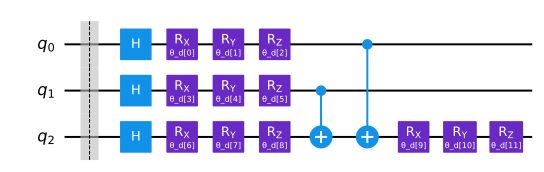

In [20]:
disc_weights = ParameterVector('θ_d', 12)
discriminator = QuantumCircuit(REAL_DIST_NQUBITS, name="Discriminator")
discriminator.barrier()
discriminator.h(0)
discriminator.rx(disc_weights[0], 0)
discriminator.ry(disc_weights[1], 0)
discriminator.rz(disc_weights[2], 0)
discriminator.h(1)
discriminator.rx(disc_weights[3], 1)
discriminator.ry(disc_weights[4], 1)
discriminator.rz(disc_weights[5], 1)
discriminator.h(2)
discriminator.rx(disc_weights[6], 2)
discriminator.ry(disc_weights[7], 2)
discriminator.rz(disc_weights[8], 2)
discriminator.cx(1,2)
discriminator.cx(0,2)
discriminator.rx(disc_weights[9], 2)
discriminator.ry(disc_weights[10], 2)
discriminator.rz(disc_weights[11], 2)
discriminator.draw()

そして、完全な回路を構築します。

In [21]:
N_GPARAMS = generator.num_parameters
N_DPARAMS = discriminator.num_parameters

### QGAN のコンパイル

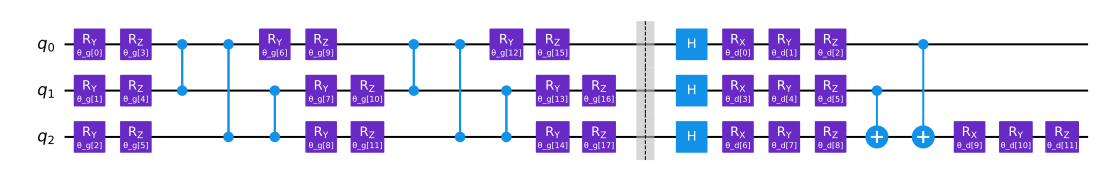

In [22]:
gen_disc_circuit = QuantumCircuit(REAL_DIST_NQUBITS)
gen_disc_circuit.compose(generator, inplace=True)
gen_disc_circuit.compose(discriminator, inplace=True)
gen_disc_circuit.draw()

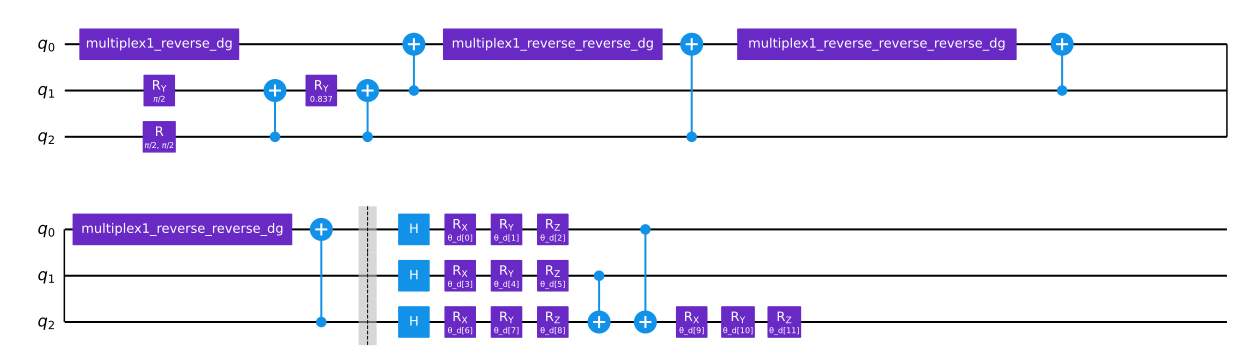

In [23]:
real_disc_circuit = QuantumCircuit(REAL_DIST_NQUBITS)
real_disc_circuit.compose(real_circuit, inplace=True)
real_disc_circuit.compose(discriminator, inplace=True)
real_disc_circuit.draw()

### OpflowQNN

Qiskit の[`OpflowQNN`](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.OpflowQNN.html)を使用します。これは (パラメータ化された) 演算子を取り、Qiskit の勾配フレームワークを活用してバックワードパスを完成させるものです。ここで定義された演算子は、最後の量子ビットに対する $Z$ の期待値に相当します。

In [24]:
from qiskit.opflow import (StateFn, PauliSumOp, Gradient,
                           AerPauliExpectation)
from qiskit_machine_learning.neural_networks import OpflowQNN
expval = AerPauliExpectation()  # method to calculcate expectation values
gradient = Gradient()
qi_sv = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))
# Circuit wave function
gen_disc_sfn = StateFn(gen_disc_circuit)
real_disc_sfn = StateFn(real_disc_circuit)
# construct operator to retrieve Pauli Z expval of the last qubit
H1 = StateFn(PauliSumOp.from_list([('ZII', 1.0)]))
# combine operator and circuit to objective function
gendisc_op = ~H1 @ gen_disc_sfn
realdisc_op = ~H1  @ real_disc_sfn

In [25]:
# construct OpflowQNN with the two operators, the input parameters,
# the weight parameters, the expected value, and quantum instance.
# |fake> => |0> => 1 ; |real> => |1> => -1
gen_opqnn = OpflowQNN(gendisc_op,
                      # input parameters (discriminator weights)
                      gen_disc_circuit.parameters[:N_DPARAMS],
                      # differentiable weights (generator weights)
                      gen_disc_circuit.parameters[N_DPARAMS:],
                      expval,
                      gradient,
                      qi_sv) # gen wants to to minimize this expval
disc_fake_opqnn = OpflowQNN(gendisc_op,
                            # input parameters (generator weights)
                            gen_disc_circuit.parameters[N_DPARAMS:],
                            # differentiable weights (discrim. weights)
                            gen_disc_circuit.parameters[:N_DPARAMS],
                            expval,
                            gradient,
                            qi_sv) # disc wants to maximize this expval
disc_real_opqnn = OpflowQNN(realdisc_op,
                            [],
                            # differentiable weights (discrim. weights)
                            gen_disc_circuit.parameters[:N_DPARAMS],
                            expval,
                            gradient,
                            qi_sv) # disc wants to minimize this expval

まず、トレーニングパラメーターを初期化し、オプティマイザーを定義します。

In [26]:
### START
init_gen_params = tf.Variable(np.random.uniform(low=-np.pi,
                                                high=np.pi,
                                                size=(N_GPARAMS)))
init_disc_params = tf.Variable(np.random.uniform(low=-np.pi,
                                                 high=np.pi,
                                                 size=(N_DPARAMS)))
gen_params = init_gen_params
disc_params = init_disc_params
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

### コスト関数の再構築

次に、学習ロジックを構築します。ここでのコスト関数には、勾配規則に影響を与える重要な違いがいくつかあります。フォワードパスは確率状態ベクトルではなく、直接的な期待値を返すようになったため、 $\langle \text{real} |Z| \text{real} \rangle = -1$ や $\langle \text{fake} |Z| \text{fake} \rangle = 1$ であったことを思い出してください。

以前と同様のロジックを適用すると、識別器が偽のデータを与えたときには $\langle \text{fake} |Z|\text{fake} \rangle $ を最大化したく、また真の量子状態を与えられた時は$\langle \text{real} |Z| \text{real}\rangle$ を最小化したいという直感を得ます。それとは対照的に、生成器は $\langle \text{fake} |Z|\text{fake} \rangle $ を最小化することを望んでいます。これは、識別器が偽のサンプルを  $|\text{real}\rangle = |1\rangle$ として分類する確率を最大化することに似ています。

これらのアイデアを、適切な期待値によって定義される次のミニマックス決定則に固めます。  $\rho^{DR}$ と $\rho^{GR}$ を それぞれ $\bigg(U_{D(\class{theta-d}{\vec{\theta_D}})}U_R |0\rangle^{\otimes n+1}\bigg)$ と  $\bigg(U_{D(\class{theta-d}{\vec{\theta_D}})} U_{G(\class{theta -g}{\vec{\theta_G}})}|0\rangle^{\otimes n+1}\bigg)$ の密度行列表現とします。また、任意の密度行列 $\rho$ に対する $\class{sigma-p}{\sigma^P}$ の期待値は $\text{tr}(\rho \sigma^P) $ として定義されることを思い出してください ([この章](/course/quantum-hardware/density-matrix)に関連する)。トレース操作の線形性を思い出すと、以下のようになります。

$\underset{\class{theta-g}{\vec{\theta_G}}}{\min} \hspace{2pt} \underset{\class{theta-d}{\vec{\theta_D}}}{\max} \hspace{3pt} \text{tr}\bigg(\big(\rho^{DG}(\class{theta-d}{\vec{\theta_D}}, \class{theta-g}{\vec{\theta_G}}) - \rho^{DR}(\class{theta-d}{\vec{\theta_D}})\Big) Z\bigg)$

これにより、次のコスト関数が得られます (最小値への最適化です)。

$\text{Cost}_D(\class{theta-d}{\vec{\theta_D}},  \class{theta-g}{\vec{\theta_G}}) =  \text{tr}\bigg(Z\rho^{DR}(\class{theta-d}{\vec{\theta_D}}) \bigg) - \text{tr}\bigg(Z\rho^{DG}(\class{theta-d}{\vec{\theta_D}}, \class{theta-g}{\vec{\theta_G}})\bigg)$

$\text{Cost}_G(\class{theta-d}{\vec{\theta_D}},  \class{theta-g}{\vec{\theta_G}}) = \text{tr}\bigg(Z \rho^{DG}(\class{theta-d}{\vec{\theta_D}}, \class{theta-g}{\vec{\theta_G}}) \bigg)$

つまり、勾配は、

$\nabla _ {\class{theta-d}{\vec{\theta_D}}}\ \text{Cost}_D(\class{theta-d}{\vec{\theta_D}},  \class{theta-g}{\vec{\theta_G}}) =  \nabla _ {\class{theta-d}{\vec{\theta_D}}}\ \text{tr}\bigg(Z\rho^{DR}(\class{theta-d}{\vec{\theta_D}}) \bigg) - \nabla _ {\class{theta-d}{\vec{\theta_D}}}\ \text{tr}\bigg(Z\rho^{DG}(\class{theta-d}{\vec{\theta_D}}, \class{theta-g}{\vec{\theta_G}})\bigg)$

$\nabla _ {\class{theta-g}{\vec{\theta_G}}} \ \text{Cost}_G(\class{theta-d}{\vec{\theta_D}},  \class{theta-g}{\vec{\theta_G}}) = \nabla _ {\class{theta-g}{\vec{\theta_G}}}\ \text{tr}\bigg(Z \rho^{DG}(\class{theta-d}{\vec{\theta_D}}, \class{theta-g}{\vec{\theta_G}}) \bigg)$

これで完成です！ `OpFlowQNN.backward()`メソッドが成分の勾配を計算するため、実装するために必要なすべての情報が得られました。これを実装しましょう。

*上記の定式化は、$|\text{real}\rangle = |1\rangle$ および $|\text{fake}\rangle = |0\rangle$ という最初の定義に依存していることに注意してください。*

### 学習

In [27]:
best_gen_params = init_gen_params
gloss, dloss, kl_div = [], [], []
TABLE_HEADERS = "Epoch | Gen. cost | Discrim. cost | KL Div | New best? |"
print(TABLE_HEADERS)
for epoch in range(300):
    D_STEPS = 5
    #--- Quantum discriminator parameter update ---#
    for disc_train_step in range(D_STEPS):
        grad_dcost_fake = disc_fake_opqnn.backward(gen_params,
                                                   disc_params)[1][0,0]
        grad_dcost_real = disc_real_opqnn.backward([],
                                                   disc_params)[1][0,0]
        grad_dcost = grad_dcost_real - grad_dcost_fake # as above
        grad_dcost = tf.convert_to_tensor(grad_dcost)
        # update disc_params
        discriminator_optimizer.apply_gradients(zip([grad_dcost],
                                                    [disc_params]))
        if disc_train_step % D_STEPS == 0:
            dloss.append(discriminator_cost(disc_params))

    #--- Quantum generator parameter update ---#
    for gen_train_step in range(1):
        # as formulated above
        grad_gcost = gen_opqnn.backward(disc_params,
                                        gen_params)[1][0,0]
        grad_gcost = tf.convert_to_tensor(grad_gcost)
        # update gen_params
        generator_optimizer.apply_gradients(zip([grad_gcost],
                                                [gen_params]))
        gloss.append(generator_cost(gen_params))

    #--- Track KL and save best performing generator weights ---#
    # Create test circuit with updated gen parameters
    gen_checkpoint_circuit = generator.bind_parameters(gen_params.numpy())
    # Retrieve probability distribution of current generator
    gen_prob_dict = Statevector(gen_checkpoint_circuit
                               ).probabilities_dict()
    # Constant real probability distribution
    real_prob_dict = Statevector(real_circuit).probabilities_dict()
    current_kl = calculate_kl_div(gen_prob_dict, real_prob_dict)
    kl_div.append(current_kl)
    new_best = (np.min(kl_div) == current_kl)
    if new_best:
        # Store new best generator weights
        # serialize & deserialize to just zero links
        best_gen_params = pickle.loads(pickle.dumps(gen_params))
    if epoch % 30 == 0:
        # print table
        for header, val in zip(TABLE_HEADERS.split('|'),
                              (epoch, gloss[-1], dloss[-1],
                               kl_div[-1], new_best)):
            print(f"{val:.3g} ".rjust(len(header)), end="|")
        print()

Epoch | Gen. cost | Discrim. cost | KL Div | New best? |
    0 |    -0.577 |         0.147 |   1.47 |         1 |
   30 |    -0.229 |        -0.732 |  0.604 |         1 |
   60 |    -0.199 |        -0.584 |   1.38 |         0 |
   90 |    -0.263 |        -0.512 |   1.39 |         0 |
  120 |    -0.199 |        -0.397 |  0.677 |         0 |
  150 |    -0.291 |        -0.488 |  0.536 |         1 |
  180 |    -0.173 |        -0.399 |  0.296 |         1 |
  210 |    -0.424 |        -0.276 |  0.669 |         0 |
  240 |    -0.381 |        -0.453 |  0.608 |         0 |
  270 |    -0.233 |        -0.453 |  0.291 |         0 |


### 結果を表示

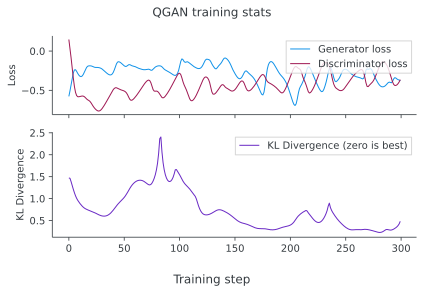

In [28]:
import matplotlib.pyplot as plt
fig, (loss, kl) = plt.subplots(2, sharex=True,
                               gridspec_kw={'height_ratios': [0.75, 1]},
                               figsize=(6,4))
fig.suptitle('QGAN training stats')
fig.supxlabel('Training step')
loss.plot(range(len(gloss)), gloss, label="Generator loss")
loss.plot(range(len(dloss)), dloss, label="Discriminator loss",
          color="C3")
loss.legend()
loss.set(ylabel='Loss')
kl.plot(range(len(kl_div)), kl_div, label="KL Divergence (zero is best)",
        color="C1")
kl.set(ylabel='KL Divergence')
kl.legend()
fig.tight_layout();

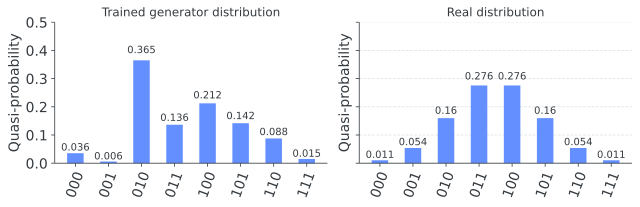

In [29]:
# Create test circuit with new parameters
gen_checkpoint_circuit = generator.bind_parameters(best_gen_params.numpy())
gen_prob_dict = Statevector(gen_checkpoint_circuit).probabilities_dict()
real_prob_dict = Statevector(real_circuit).probabilities_dict() # constant
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(9,3))
plot_histogram(gen_prob_dict, ax=ax1)
ax1.set_title("Trained generator distribution")
plot_histogram(real_prob_dict, ax=ax2)
ax2.set_title("Real distribution")
ax2.set_ylim([0,.5])
fig.tight_layout()

お見事です！

<!-- ::: q-block.exercise -->

### クイッククイズ

疑似コードの行を正しい順序にドラッグして、プログラムを完成させます。

    q-drag-and-drop-code
        .line For n:=0 to N_EPOCHS do:
            .line For d:=0 to num_disc_steps do:
                .line Compute Z expectation value of d_out qubit when fed fake and real data
                .line.md Update  `{latex}\class{theta-d}{\vec{\theta_D}}`  according to  `{latex}\nabla_{\vec{\theta}_{D}}\text{Cost}_D(\class{theta-d}{\vec{\theta_D}},\class{theta-g}{\vec{\theta_G}})`  using ADAM optimizer
            .line For g:=0 to num_gen_steps do
                .line Compute Z-expectation value of d_out qubit when fed fake data
                .line.md Update  `{latex}\vec{\theta}_{G}`  according to  `{latex}\nabla_{\vec{\theta}_G}\text{Cost}_G(\class{theta-d}{\vec{\theta_D}},\class{theta-g}{\vec{\theta_G}})`  using ADAM optimizer
            .line Compute KL divergence between G and R
            .line If current KL divergence is the lowest yet do
                .line Save current generator weights

<!-- ::: -->

## 応用の可能性

QGANの開発はまだ始まったばかりであり、その応用についてはまだまだ研究が必要です。しかし、古典的に困難な確率分布（古典的にサンプリングが困難な分布）のサンプリングや操作を可能にすることが期待されています。

QGANの応用として特に興味深いのは、効率的な近似的なデータの読み込みです。データ処理において量子の利点を享受するためには、例えば、量子振幅推定 [6] などを用いる場合、入力データを量子状態にロードする必要があります。しかし、古典的なデータを量子回路にロードするのはコストが高く、一般に指数関数的に高くなります[7, 8]。したがって、データロードの複雑さは、潜在的な量子の利点を簡単に損なう可能性があります。

この[チュートリアル](https://qiskit.org/documentation/machine-learning/tutorials/04_qgans_for_loading_random_distributions.html)で示されているように、QGANは一般的な確率分布の近似値を効率的に学習し、読み込みを効率的に行う興味深いアプローチを提供します（参考文献[4]）。確率分布が量子状態にロードされると、量子振幅推定などの量子アルゴリズムがデータを処理できます。この[チュートリアル](https://qiskit.org/documentation/tutorials/finance/10_qgan_option_pricing.html)示されているように、このワークフローは、例えば、オプション価格の問題を二次関数的に高速化するために使用される可能性があります。

さらに、量子化学の分野では、量子コンピューターは、相関のある[フェルミオン](gloss:fermionic)状態 (分子) を表現および操作できるという本質的な利点があると考えられています。適切なansatzがあれば、QGAN を使用して、VQE で得られた物質や分子の型にはまるような新しいタイプの分子を生成することができるでしょうか？それには、QGANを条件付き領域に拡張する必要があります。（条件付きラベルを生成器と識別器の両方に入力します。[条件付きGAN](https://arxiv.org/abs/1411.1784)を参照してください。ただし、現時点では未解決の問題です。)

<!-- ::: q-block.exercise -->

### 試してみよう

今回学んだアイデアを拡張するには、QGAN を作成して 3 量子ビットの正規分布を学習する際に、古典的な識別器を使用してみます。[参考文献4](https://arxiv.org/abs/1904.00043)が参考になります。上で使用したのと同じ生成器の ansatz を使用できますが、識別器のニューラル ネットワークが、量子生成器の能力に一致するように適切なサイズであることを確認してください。

[IBM Quantum Lab で試してみましょう](https://quantum-computing.ibm.com/lab)

<!-- ::: -->

## 参考文献

<!-- vale QiskitTextbook.Spelling = NO -->

1. I. J. Goodfellow, J. Pouget-Abadie, M. Mirza, B. Xu, D.Warde-Farley, S. Ozair, A. Courville, and Y. Bengio, in *Proceedings of the 27th International Conference on Neural Information Processing Systems* (MIT Press, Cambridge, MA, 2014), Vol. 2, pp. 2672–2680, [arXiv:1406.2661](https://arxiv.org/abs/1406.2661).
2. P.-L. Dallaire-Demers, &amp; N. Killoran, *Quantum generative adversarial networks,* Phys. Rev. A 98, 012324 (2018), [doi.org:10.1103/PhysRevA.98.012324](https://doi.org/10.1103/PhysRevA.98.012324), [arXiv:1804.08641](https://arxiv.org/abs/1804.08641)
3. S. Lloyd, &amp; C. Weedbrook, *Quantum generative adversarial learning*. Phys. Rev. Lett. 121, 040502 (2018), [doi.org:10.1103/PhysRevLett.121.040502](https://doi.org/10.1103/PhysRevLett.121.040502), [arXiv:1804.09139](https://arxiv.org/abs/1804.09139)
4. C. Zoufal, A. Lucchi, and S. Woerner, *Quantum generative adversarial networks for learning and loading random distributions,* npj Quantum Information, 5, Article number: 103 (2019), [doi.org/10.1038/s41534-019-0223-2](https://doi.org/10.1038/s41534-019-0223-2), [arXiv:1904.00043](https://arxiv.org/abs/1904.00043)
5. J. Romero, A. Aspuru-Guzik, *Variational quantum generators: Generative adversarial quantum machine learning for continuous distributions* (2019), [arxiv.org:1901.00848](https://arxiv.org/abs/1901.00848)
6. Brassard, G., Hoyer, P., Mosca, M. &amp; Tapp, A. *Quantum amplitude amplification and estimation*. Contemp. Math. 305, 53–74 (2002), [doi.org/10.1090/conm/305/05215](http://www.ams.org/books/conm/305/), [arXiv:quant-ph/0005055](https://arxiv.org/abs/quant-ph/0005055)
7. L. K. Grover. *Synthesis of quantum superpositions by quantum computation*. Phys. Rev. Lett., 85, (2000), [doi.org/10.1103/PhysRevLett.85.1334](https://link.aps.org/doi/10.1103/PhysRevLett.85.1334)
8. M. Plesch and ˇC. Brukner. *Quantum-state preparation with universal gate decompositions*. Phys. Rev. A, 83, (2010), [doi.org/10.1103/PhysRevA.83.032302](https://doi.org/10.1103/PhysRevA.83.032302)

In [30]:
# pylint: disable=unused-import
import qiskit.tools.jupyter
%qiskit_version_table